# K-Nearest Neighbors

This model consists oflooking at nearby observations, and using their outcomes to establish the value of a new observation. `K` stands for the number of records to be used for this prediction. In regression, the outcome will be an average of the predictor's y variable, while for classification, which is the case for this excercise, a majority vote is used.

In this model, `k` can be seen as a tuning parameter. using a small `k` allows the model to be more localized and hence reflect changes more precisely. This also means that small values of this tuning parameter make the model more complex. 

# Load Libraries

In [73]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import Data

In [74]:
X_train = pd.read_csv('0_X_train.csv', index_col='Id')
X_valid = pd.read_csv('1_X_valid.csv', index_col='Id')
X_test  = pd.read_csv('2_X_test.csv', index_col='Id')

y_train = pd.read_csv('0_y_train.csv', index_col='Id')
y_valid = pd.read_csv('1_y_valid.csv', index_col='Id')
y_test  = pd.read_csv('2_y_test.csv', index_col='Id')

num_vars = ['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']

#full training set
X = pd.concat([X_train, X_valid, X_test], axis=0)
y = pd.concat([y_train, y_valid, y_test], axis=0)


We modify the Y values to format correctly as per the  `scikitlearn` functions.

In [75]:
y_train = np.array(y_train)
y_train = y_train.ravel()

y = np.array(y)
y = y.ravel()

We begin by standardizing the data. As Knn models use euclidean distance to find the closest records, it is very important that these values are all in the same scale. As clarification, we use z-score normalization given by

\begin{align}
z=\frac{x - \bar{x}}{S}
\end{align}

In [76]:
#scale the data
preprocessor = ColumnTransformer(transformers=
                                 [('num', StandardScaler(), num_vars)],
                                  remainder='passthrough')

#create pipeline 
np.random.seed(1)
knn_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn_model", KNeighborsClassifier(n_neighbors=1))
])

#fit the model to the taining data
knn1 = knn_pipe.fit(X_train, y_train)

Now that the model has been fitted, it can be used to predict the outcome.

In [77]:
#predict values for all partitions
y_hat = knn1.predict(X_train)
y_hat_valid = knn1.predict(X_valid)
y_hat_test = knn1.predict(X_test)

We see the model performance by printing the accuracy on each of the sets.

In [78]:
#print results of the accuracy
print("Training accuracy:", accuracy_score(y_hat, y_train))
print("Validation accuracy:", accuracy_score(y_hat_valid, y_valid))
print("Test accuracy:", accuracy_score(y_hat_test, y_test))

Training accuracy: 1.0
Validation accuracy: 0.759493670886076
Test accuracy: 0.7661950856291884


# Find Best K

The previous results uses `k` = 1 neighbor. As mentioned this creates a very localized model which is highly complex. However, there could be improvements in accuracy if this tunig parameter is increased to see the values of various other neighbors. As so proceed to use `GridSearch()` to generate a set of combinations of models with different tunig parameters, namely `k`.

Additionally, to measure the results we use **cross validation** to test results.

In [79]:
#create cross validation folds
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

#initiate classifier
knn_best = KNeighborsClassifier()

#establish parameter grid
hyper_parameters = {"n_neighbors" : np.arange(1, 50, 2)}

In [80]:
#generate models
knnCV = GridSearchCV(estimator=knn_best, param_grid=hyper_parameters, scoring = "accuracy",
                       cv=folds)
knnCV.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
             scoring='accuracy')

We display the results to see all the models trained and their parameters.

In [81]:
pd.DataFrame(knnCV.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004574,0.000760,0.026299,0.001976,1,{'n_neighbors': 1},0.767145,0.773525,0.792663,0.789474,0.784689,0.763955,0.774760,0.777955,0.746006,0.758786,0.772896,0.013672,25
1,0.004875,0.000624,0.026481,0.001163,3,{'n_neighbors': 3},0.824561,0.787879,0.802233,0.800638,0.800638,0.784689,0.808307,0.792332,0.793930,0.785942,0.798115,0.011477,16
2,0.004429,0.000425,0.027975,0.001863,5,{'n_neighbors': 5},0.840510,0.786284,0.799043,0.797448,0.810207,0.797448,0.813099,0.805112,0.777955,0.771565,0.799867,0.018546,11
3,0.004534,0.000463,0.027254,0.001444,7,{'n_neighbors': 7},0.846890,0.797448,0.821372,0.800638,0.794258,0.789474,0.805112,0.797125,0.789137,0.779553,0.802101,0.018255,8
4,0.004634,0.000518,0.028639,0.002155,9,{'n_neighbors': 9},0.846890,0.808612,0.813397,0.799043,0.803828,0.779904,0.811502,0.808307,0.785942,0.787540,0.804497,0.017955,2


Next, to find the best, we extract the Accuracy and we save it to a new variable.

In [82]:
resCV = knnCV.cv_results_

#extract parameters
test_accs = resCV["mean_test_score"]
std_test_accs = resCV["std_test_score"] / np.sqrt(folds.get_n_splits())
k_grid = resCV["param_n_neighbors"].data

index_best = np.argmax(test_accs) # index of the k value with the highest accuracy
best_k = k_grid[index_best]
best_k

11

In [83]:
#determine the k parameters whitin the 1 standard deviation rule
one_std_rule_best_k = np.max(k_grid[test_accs <= test_accs[index_best] - std_test_accs[index_best]])
one_std_rule_best_k

49

In [84]:
# Choose best model that minimizes cv_error
mean_scores = knnCV.cv_results_["mean_test_score"]
std_scores = knnCV.cv_results_["std_test_score"] / np.sqrt(knnCV.n_splits_)
k_values = knnCV.cv_results_["param_n_neighbors"].data

best_index = np.argmax(mean_scores)
max_k = k_values[best_index]
threshold_knn = mean_scores[best_index] - std_scores[best_index]
one_std_rule_best_k = np.max(k_values[mean_scores <= threshold_knn])

print("best K:", max_k)
print("1-SD K:", one_std_rule_best_k)
print("Best score for K:", np.max(mean_scores))

best K: 11
1-SD K: 49
Best score for K: 0.8048134786574336


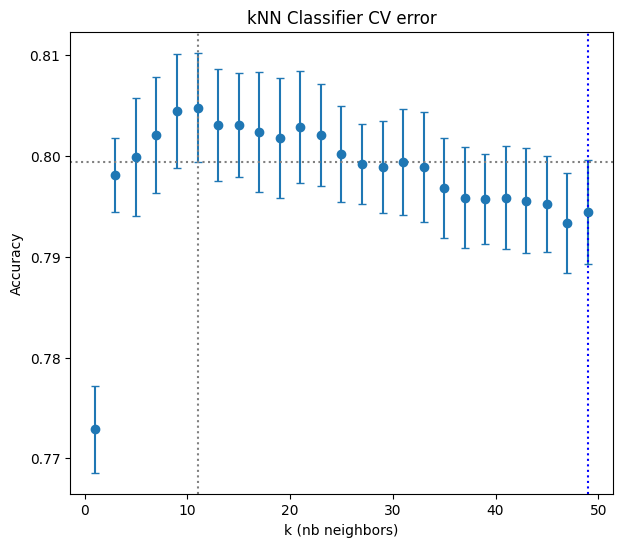

In [85]:
#create plot
plt.figure(figsize=(7,6))
plt.errorbar(x=k_grid, y=test_accs, yerr=std_test_accs, fmt='o', capsize=3)

plt.axvline(best_k, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_std_rule_best_k, ls='dotted', color="blue")#vertical line at best k value according to 1 std err rule
plt.axhline(test_accs[index_best] - std_test_accs[index_best], ls='dotted', color="gray")

plt.title("kNN Classifier CV error")
plt.xlabel('k (nb neighbors)')
plt.ylabel('Accuracy')
plt.show()

# Optimal KNN

Having determined the best model, we can create a new instance for prediction.

In [86]:
np.random.seed(1)
knn_pipe_opt = Pipeline([
    ("preprocessor", preprocessor),
    ("knn_model", KNeighborsClassifier(n_neighbors=one_std_rule_best_k))
])

In addition to the regular partitions, the models are fitted and used to predict the values of the complete data set provided. This is to see if using the whole data set can allow for more information to captured and hence provide better predictions.

## Results: k-NN Best Model

In [87]:
#Print the results
print("KNN Best Model")
print(" ")

#fit and predict on partitioned data set
knn_pipe_opt.fit(X_train, y_train)
y_hat = knn_pipe_opt.predict(X_train)
y_hat_valid = knn_pipe_opt.predict(X_valid)
y_hat_test = knn_pipe_opt.predict(X_test)
y_hat_train_full = knn_pipe_opt.predict(X)
print("Training accuracy:", round(accuracy_score(y_hat, y_train),4))
print("Validation accuracy:", round(accuracy_score(y_hat_valid, y_valid),4))
print("Test accuracy:", round(accuracy_score(y_hat_test, y_test),4))
print("X accuracy for Partially Trained Model:", round(accuracy_score(y_hat_train_full, y),4))

#fit and predict on all data
knn_pipe_opt.fit(X, y)
y_hat_full = knn_opt_full.predict(X)
print("X accuracy on Fully Trained Model:", round(accuracy_score(y_hat_full, y),4))


KNN Best Model
 
Training accuracy: 0.7774
Validation accuracy: 0.7416
Test accuracy: 0.7558
X accuracy for Partially Trained Model: 0.7688
X accuracy on Fully Trained Model: 0.7856


As observed, there is no significant difference with respect to the full data set predictions with respect to which model is used. It also presents no large improvements with respect to the prediction on the partitions. 